<a href="https://colab.research.google.com/github/SuryaVikram/MachineTranslationLSTM/blob/master/MachineTranslationSPtoENG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
file = open("/spa.txt", mode='rt', encoding='utf-8')

In [0]:
text = file.read()

In [0]:
sents = text.strip().split('\n')

In [127]:
sents[1]

'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'

In [0]:
import pandas as pd
import numpy as np
import re
import warnings
import unidecode
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore")

In [0]:
def read_text(filename):
  file = open(filename,mode='rt',encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [0]:
def to_lines(text):
  sents = text.strip().split("\n")
  sents = [i.split("\t") for i in sents]
  return sents

In [0]:
txt = read_text("/spa.txt")

In [0]:
sp_eng = to_lines(txt)

In [133]:
len(sp_eng)

123770

In [0]:
sp_eng = np.array(sp_eng)
eng1=[]
sp1=[]

In [0]:
eng1=sp_eng[:,0]
sp1=sp_eng[:,1]

In [0]:
data=pd.DataFrame({'spa':sp1,'eng':eng1})

In [137]:
data.tail()

,spa,eng
123765,"Hay cuatro causas principales de muertes relacionadas con el alcohol. Lesión por un accidente automovilístico o violencia es una. Enfermedades como cirrosis del hígado, cáncer, enfermedades del co...","There are four main causes of alcohol-related death. Injury from car accidents or violence is one. Diseases like cirrhosis of the liver, cancer, heart and blood system diseases are the others."
123766,"Hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico, o cómo ahorrar el suficiente diner...","There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college educ..."
123767,Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque está...,A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climat...
123768,"Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ...","Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo..."
123769,"Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ...","If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t..."


In [0]:
data.drop_duplicates(subset=['spa'],inplace=True)

In [0]:
def cleaner(text):
  newString = text.lower()
  unaccentedString = unidecode.unidecode(newString)
  newString = re.sub("'","",unaccentedString)
  newString = re.sub("[^a-zA-Z]"," ",newString)
  tokens = newString.split()
  return (" ".join(tokens)).strip() 

In [0]:
data['cleaned_eng'] = data["eng"].apply(cleaner)
data['cleaned_spa'] = data["spa"].apply(cleaner)

In [141]:
data.tail()

,spa,eng,cleaned_eng,cleaned_spa
123765,"Hay cuatro causas principales de muertes relacionadas con el alcohol. Lesión por un accidente automovilístico o violencia es una. Enfermedades como cirrosis del hígado, cáncer, enfermedades del co...","There are four main causes of alcohol-related death. Injury from car accidents or violence is one. Diseases like cirrhosis of the liver, cancer, heart and blood system diseases are the others.",there are four main causes of alcohol related death injury from car accidents or violence is one diseases like cirrhosis of the liver cancer heart and blood system diseases are the others,hay cuatro causas principales de muertes relacionadas con el alcohol lesion por un accidente automovilistico o violencia es una enfermedades como cirrosis del higado cancer enfermedades del corazo...
123766,"Hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico, o cómo ahorrar el suficiente diner...","There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college educ...",there are mothers and fathers who will lie awake after the children fall asleep and wonder how theyll make the mortgage or pay their doctors bills or save enough for their childs college education,hay madres y padres que se quedan despiertos despues de que sus hijos se hayan dormido y se preguntan como conseguir pagar la hipoteca o las facturas del medico o como ahorrar el suficiente dinero...
123767,Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque está...,A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climat...,a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate...,una huella de carbono es la cantidad de contaminacion de dioxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque estan...
123768,"Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ...","Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo...",since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has pop up advertising i just go to the next page found by googl...,como suele haber varias paginas web sobre cualquier tema normalmente solo le doy al boton de retroceso cuando entro en una pagina web que tiene anuncios en ventanas emergentes simplemente voy a la...
123769,"Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ...","If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t...",if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until th...,si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en qu

In [0]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(data['cleaned_spa'],data['cleaned_eng'],test_size=0.2,random_state=0,shuffle=True)

In [0]:
x_val_original = x_val
y_val_original = y_val

x_val_original.reset_index(inplace=True, drop = True)
y_val_original.reset_index(inplace=True, drop = True)

In [0]:
def build_vocab(texts):
  sentences = texts.apply(lambda x: x.split()).values
  vocab={}
  for sentence in sentences:
    for word in sentence:
      try:
        vocab[word]+=1
      except KeyError:
        vocab[word]=1
  return vocab

source_word_freq = build_vocab(x_tr)


In [0]:
#source_word_freq

In [146]:
thresh = 2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in source_word_freq.items():
  tot_cnt = tot_cnt+1
  tot_freq=tot_freq+value

  if value<thresh:
    cnt=cnt+1
    freq=freq+value
print("% of words less than thresh:", (cnt/tot_cnt)*100)
print("freq of rare words:", (freq/tot_freq) *100)


% of words less than thresh: 42.32124983680752
freq of rare words: 1.6855733982719623


In [0]:
source_word_index={}

cnt=2

for key,value in source_word_freq.items():
  if value>thresh:
    source_word_index[key]=cnt
    cnt+=1
source_word_index['<pad>']=0
source_word_index['<unk>']=1

In [0]:
source_vocab=[key for key,value in source_word_index.items()]


source_seq_tr=[]

for i in x_tr:
  seq=[]
  for j in i.split():
    if(j not in source_vocab):
      seq.append(source_word_index['<unk>'])
    elif source_word_freq[j]<thresh:
      seq.append(source_word_index['<unk>'])
    else:
      seq.append(source_word_index[j])
  source_seq_tr.append(seq)
  



In [149]:
source_seq_tr[:5]

[[2, 3], [4, 5, 6], [7, 8, 9, 10, 8, 11], [12, 1, 8, 9, 13, 14, 15, 16], [17]]

In [0]:
source_seq_val=[]

for i in x_val:
  seq=[]
  for j in i.split():
    if(j not in source_vocab):
      seq.append(source_word_index['<unk>'])
    elif source_word_freq[j]<thresh:
      seq.append(source_word_index['<unk>'])
    else:
      seq.append(source_word_index[j])
  source_seq_val.append(seq)

In [0]:
target_word_freq=build_vocab(y_tr)

In [152]:
thresh = 2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in target_word_freq.items():
  tot_cnt = tot_cnt+1
  tot_freq=tot_freq+value

  if value<thresh:
    cnt=cnt+1
    freq=freq+value
print("% of words less than thresh:", (cnt/tot_cnt)*100)
print("freq of rare words:", (freq/tot_freq) *100)

% of words less than thresh: 33.87978142076503
freq of rare words: 0.6963034233521461


In [0]:
target_word_index={}

cnt=4

for key,value in target_word_freq.items():
  if value>thresh:
    target_word_index[key]=cnt
    cnt+=1
target_word_index['<pad>']=0
target_word_index['<unk>']=1

In [0]:
target_vocab=[key for key,value in target_word_index.items()]


target_seq_tr=[]

for i in y_tr:
  seq=[]
  for j in i.split():
    if(j not in target_vocab):
      seq.append(target_word_index['<unk>'])
    elif target_word_freq[j]<thresh:
      seq.append(target_word_index['<unk>'])
    else:
      seq.append(target_word_index[j])
  target_seq_tr.append(seq)


target_seq_val=[]

for i in y_val:
  seq=[]
  for j in i.split():
    if(j not in target_vocab):
      seq.append(target_word_index['<unk>'])
    elif target_word_freq[j]<thresh:
      seq.append(target_word_index['<unk>'])
    else:
      seq.append(target_word_index[j])
  target_seq_val.append(seq)

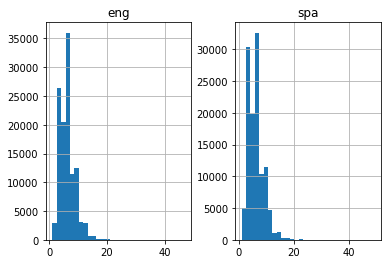

In [155]:
eng_word_cnt=[]
spa_word_cnt=[]


for i in data['eng']:
  eng_word_cnt.append(len(i.split()))

for i in data['spa']:
  spa_word_cnt.append(len(i.split()))


length_df=pd.DataFrame({'eng':eng_word_cnt,'spa':spa_word_cnt})
length_df.hist(bins=30)
plt.show()


In [0]:
max_eng_len=15
max_spa_len=15

In [0]:
x_tr=pad_sequences(source_seq_tr,maxlen=max_spa_len,padding='post',truncating='post')
x_val=pad_sequences(source_seq_val,maxlen=max_spa_len,padding='post',truncating='post')
x_voc=len(source_vocab)

In [0]:
y_tr_pad=pad_sequences(target_seq_tr,maxlen=max_eng_len,padding='post',truncating='post')
y_val_pad=pad_sequences(target_seq_val,maxlen=max_eng_len,padding='post',truncating='post')

In [0]:
target_word_index['<start>']=2
target_word_index['<end>']=3

y_tr_start=[]

for i in y_tr_pad:
  temp = np.insert(i,0,target_word_index['<start>'])
  y_tr_start.append(temp)

y_tr=[]
for i in y_tr_start:
  if(0 in list(i)):
    temp = np.insert(i,list(i).index(0),target_word_index['<end>'])
  else:
    temp = np.insert(i,len(i),target_word_index['<end>'])
  y_tr.append(temp)


y_tr=np.array(y_tr)




In [0]:
y_voc=len(target_word_index)

In [0]:
y_val_start=[]

for i in y_val_pad:
  temp = np.insert(i,0,target_word_index['<start>'])
  y_val_start.append(temp)

y_val=[]
for i in y_val_start:
  if(0 in list(i)):
    temp = np.insert(i,list(i).index(0),target_word_index['<end>'])
  else:
    temp = np.insert(i,len(i),target_word_index['<end>'])
  y_val.append(temp)


y_val=np.array(y_val)

In [0]:
max_eng_len=max_eng_len+2

In [0]:
latent_dim = 150
embedding_dim= 200

In [0]:
encoder_inputs = Input(shape=(max_spa_len,))
enc_emb = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h, state_c = encoder_lstm(enc_emb) 


In [0]:
decoder_inputs = Input(shape=(max_eng_len-1,))
dec_emb_layer= Embedding(y_voc,embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_output,dec_state_h,dec_state_c = decoder_lstm(dec_emb,initial_state=[state_h,state_c])

decoder_dense=TimeDistributed(Dense(y_voc,activation='softmax'))
decoder_outputs = decoder_dense(decoder_output)


In [172]:
model=Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 15, 200)      1936400     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 16, 200)      1273800     input_7[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

In [0]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=3,min_delta=0.0001,mode='min')
mc= ModelCheckpoint('/best_model_v4.h5',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

In [181]:
history = model.fit([x_tr,y_tr[:,:-1]],y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)[:,1:],
                    epochs=100,callbacks=[es,mc],batch_size=512,
                    validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:,1:]))

Train on 94114 samples, validate on 23529 samples
Epoch 1/100
94114/94114 [==============================] - 562s 6ms/step - loss: 2.8865 - val_loss: 2.3460

Epoch 00001: val_loss improved from inf to 2.34601, saving model to /best_model_v4.h5
Epoch 2/100
94114/94114 [==============================] - 561s 6ms/step - loss: 2.2344 - val_loss: 2.0791

Epoch 00002: val_loss improved from 2.34601 to 2.07915, saving model to /best_model_v4.h5
Epoch 3/100
94114/94114 [==============================] - 568s 6ms/step - loss: 1.9855 - val_loss: 1.8929

Epoch 00003: val_loss improved from 2.07915 to 1.89288, saving model to /best_model_v4.h5
Epoch 4/100
94114/94114 [==============================] - 556s 6ms/step - loss: 1.8275 - val_loss: 1.7725

Epoch 00004: val_loss improved from 1.89288 to 1.77249, saving model to /best_model_v4.h5
Epoch 5/100
94114/94114 [==============================] - 557s 6ms/step - loss: 1.7107 - val_loss: 1.6776

Epoch 00005: val_loss improved from 1.77249 to 1.67756

In [0]:
model = load_model("/best_model_v4.h5")
model.save_weights('/best_model_weights_v4.h5')